<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Permeability_from_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [6]:
!pip install GitPython
from git import Repo
# !git clone https://github.com/MariiaKalinina/Elasticity.git
!git clone https://github.com/MariiaKalinina/Elasticity.git NewElasticity_v1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00
Cloning into 'NewElasticity_v1'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 285 (delta 118), reused 117 (delta 73), pack-reused 100
Receiving objects: 100% (285/285), 11.35 MiB | 23.73 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [15]:
path_to_ser = Path('/content/NewElasticity_v1/Tver_ver1.xlsx')
df_ues = pd.read_excel(path_to_ser, sheet_name='All properties_data', skiprows=0)

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [17]:
data = df_ues.copy()
data.drop('#', axis=1, inplace=True)

In [18]:
data[:5]

,Sample,Well,Litholohy,"Porosity,%",Permeability,Density (water),Density (oil),Vp air,Vs air,Vp oil,Vs oil,Vp water,Vs water,Unnamed: 14,AR thermal,AO electrical,Unnamed: 17,Unnamed: 18,TC air,TC oil,"TC 0,6",TC 6,TC 60,TC 180
0,113480,a,"пористо-кавернозный, скол на торце, закрытые и полуоткрытые трещины",4.524900,0.832741,2.572247,2.576227,5.037000,2.360000,5.564425,3.019440,5.2945,2.6495,NaN,0.066681,0.069183,NaN,NaN,2.472888,2.668885,NaN,2.740225,2.966438,2.852613
1,113532,a,пористо-кавернозный,6.473371,0.253703,2.537162,2.529374,4.042333,2.427667,5.173550,2.849075,5.0545,2.6650,NaN,0.134276,0.087096,NaN,NaN,2.404575,2.600888,2.745500,2.741125,2.857375,2.834588
2,113536,a,пористо-кавернозный,15.024288,18.334600,2.285245,2.297374,3.514333,1.997000,4.103260,2.256210,4.0285,2.2330,NaN,0.131826,0.104713,NaN,NaN,1.858550,2.234582,2.535225,2.514712,2.630950,2.677875
3,113541,a,пористо-кавернозный,14.192654,17.343900,2.326067,2.319278,3.241000,1.837667,3.971235,2.164210,3.8155,2.0285,NaN,0.122462,0.095499,NaN,NaN,1.867175,2.286873,2.619337,2.604425,2.728613,2.715700
4,113556,a,пористо-кавернозный,9.432966,15.777000,2.459785,2.445896,3.798667,2.336333,4.759910,2.564645,4.8270,2.5030,NaN,0.081658,0.072444,NaN,NaN,2.123563,2.400862,2.661125,2.623087,2.823100,2.718675


In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
# layout='constrained'
# fig.tight_layout(pad=0.001000)
axs = fig.subplots(1, 2,  sharex=False)

ticks_size, label_size = 16, 18

        ### Porosity VS Permeability (all samples)
x_value, y_value = "Porosity,%", "Permeability"

  ### INPUT DATA
axs[0].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[0].set_xscale("linear")
axs[0].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[0].set_xlim([0, 25])
axs[0].set_xticks(np.arange(0, 26, 5))
axs[0].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[0].set_yscale('log', base=10)
axs[0].grid(which='major', axis='both', linestyle='-')

axs[0].set_yscale('log')
axs[0].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[0].set_ylim([10**-2, 10**4])
axs[0].set_yticks(np.logspace(-2, 4, num=7))
axs[0].set_yticklabels(np.logspace(-2, 4, num=7), fontsize=ticks_size)



  ### INPUT DATA - 2
axs[1].scatter(df_ues[x_value], df_ues[y_value], color='Black', s=50)
axs[1].set_xscale("linear")
axs[1].set_xlabel("$К_{п}, $"+"$\%$", fontsize=label_size, fontweight='bold')
axs[1].set_xlim([0, 25])
axs[1].set_xticks(np.arange(0, 26, 5))
axs[1].set_xticklabels(np.arange(0, 26, 5), fontsize=ticks_size)
axs[1].set_yscale('log', base=10)
axs[1].grid(which='major', axis='both', linestyle='-')

axs[1].set_yscale('log')
axs[1].set_ylabel('${k}, мД$', fontsize=label_size, fontweight='bold')
axs[1].set_ylim([10**-1, 10**4])
axs[1].set_yticks(np.logspace(-1, 4, num=6))
axs[1].set_yticklabels(np.logspace(-1, 4, num=6), fontsize=ticks_size)


plt.show()

Границы ХШ

In [12]:
def Upper_Hashin_Strikman(phi, lam):
    L0 = max(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    # print('TC Upper Hashin-Strikman:', L_eff)
    return L_eff


def Lower_Hashin_Strikman(phi, lam):
    L0 = min(lam)
    f = 1 / 3  # Границы ХШ - частный случай ОСП, тело сравние - мин.матрица=верхняя граница; флюид=нижняя граница.
                # Все включения только сферические АО=1, F деполяризации 1/3
    HS_comp1, HS_comp2 = [], []

    for i, j in zip(phi, lam):
        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all
        t15 = termz_all

        HS_comp1.append(t16)  # параллельная компонента ТС
        HS_comp2.append(t15)  # перпендикулярная компонента ТС
    i = 0
    for k in HS_comp1:
        i += k
    j = 0
    for k in HS_comp2:
        j += k

    L_eff = i / j
    return L_eff

def Average_Hashin_Strikman(phi, lam):
    return np.mean([Lower_Hashin_Strikman(phi, lam), Upper_Hashin_Strikman(phi, lam)])

ОСП - теплопроводность, проницаемость

In [ ]:
def effective_tc(conc, alpha_shape, lam):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]

    def raschet(L0):

        parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

        for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

            termc_3 = i * j / (L0 * (1-f)+j * f)
            termz_3 = i / (L0 * (1-f)+j * f)

            termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
            termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

            termc_all = (termc_3+2 * termc_12) / 3
            termz_all = (termz_3+2 * termz_12) / 3

            t16 = termc_all # числитель
            t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

            parall_comp.append(t16)  # числитель формулы (матрица, флюид)
            perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

        L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
        return L_eff

    x0 = L0
    L0 = raschet(x0)
    it_f = 1
    while abs(x0-L0) >= 10 **-6:
        x0 = L0
        L0 = raschet(x0)
        it_f += 1

#     print('Количество итераций: ', it_f, end='\n\n')
    return L0
#     print('Эффективное значение TC_eff:', raschet(L0))


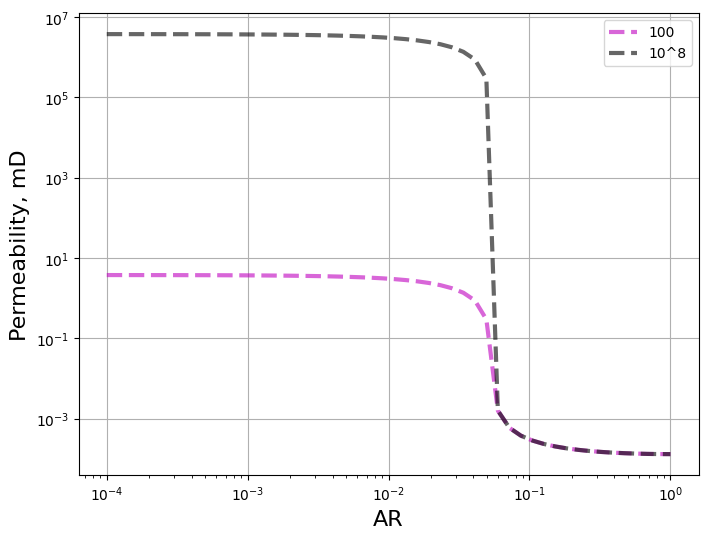

In [ ]:
ar_inclusion_list = np.logspace(-4, 0, num=50, base=10)
porosity = 0.08

calculation_perm_1, calculation_perm_2 =[], []

for ar_inclusion in ar_inclusion_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_inclusion]
  calculation_perm_1.append(effective_tc(conc, alpha_shape, [10**-4, 10**2]))
  calculation_perm_2.append(effective_tc(conc, alpha_shape, [10**-4, 10**8]))

fig, axs = plt.subplots(figsize=(8, 6))
axs.plot(ar_inclusion_list, calculation_perm_1, 'm--', lw=3, alpha=0.6, label='100')
axs.plot(ar_inclusion_list, calculation_perm_2, 'k--', lw=3, alpha=0.6, label='10^8')
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability, mD', fontsize=16)
axs.set_xlabel('AR', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

Анализ чувствительности «Матричная» проницаемость к АО пор (оценка по диапазону АО, инвертированному по теплопроводности: 0.07-0.28)

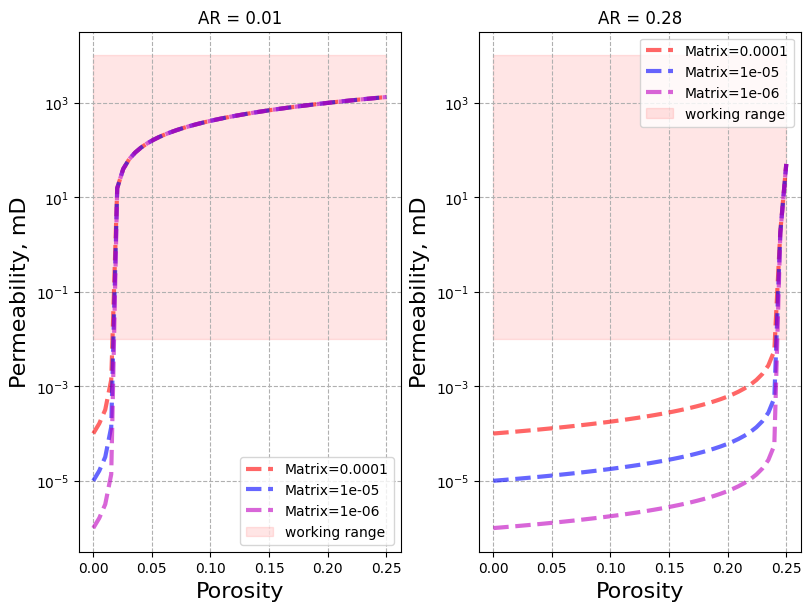

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity

    alpha_shape = [1, ar_fluid]

    mlam = [10**-4, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-5, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    mlam = [10**-6, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'Matrix={mlam[0]}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

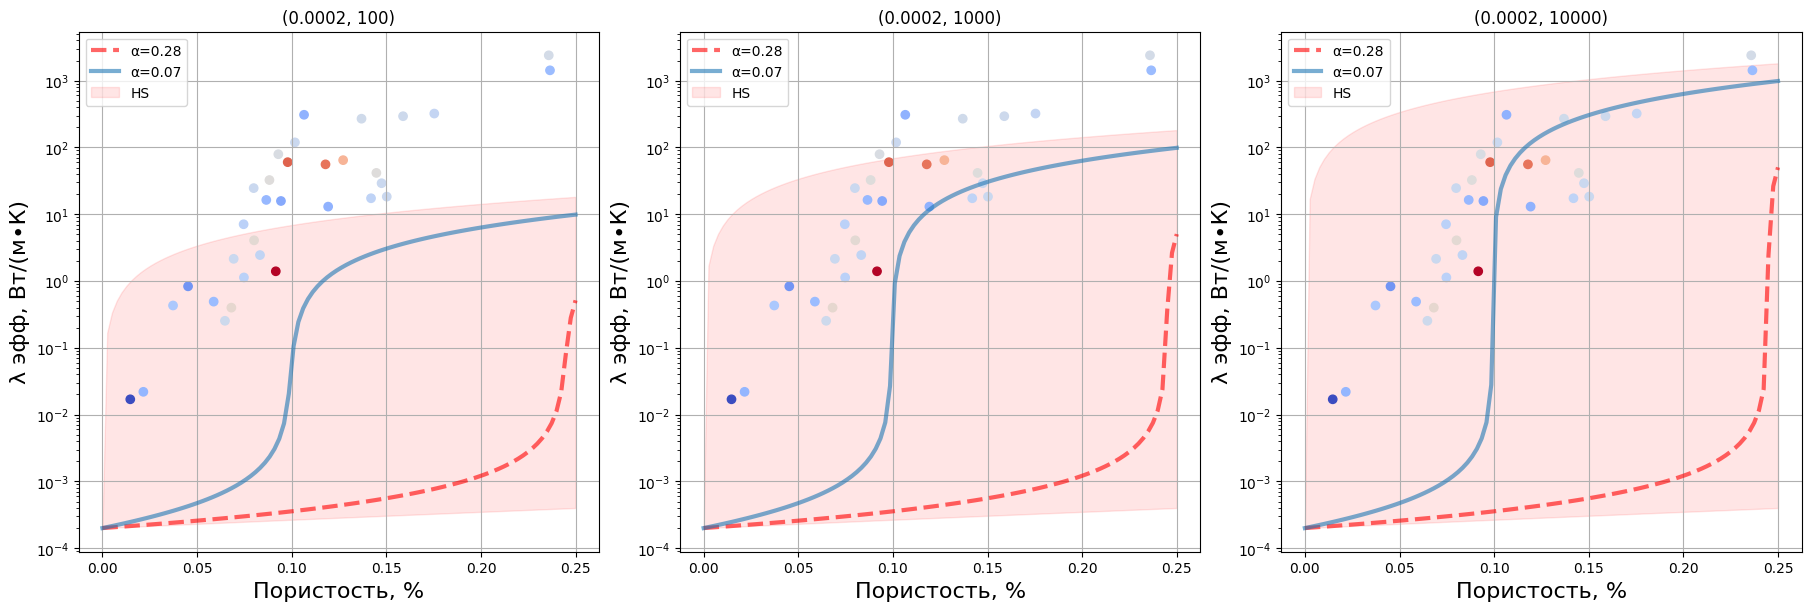

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**2),
              (mtrx_perm, 10**3),
              (mtrx_perm, 10**4)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

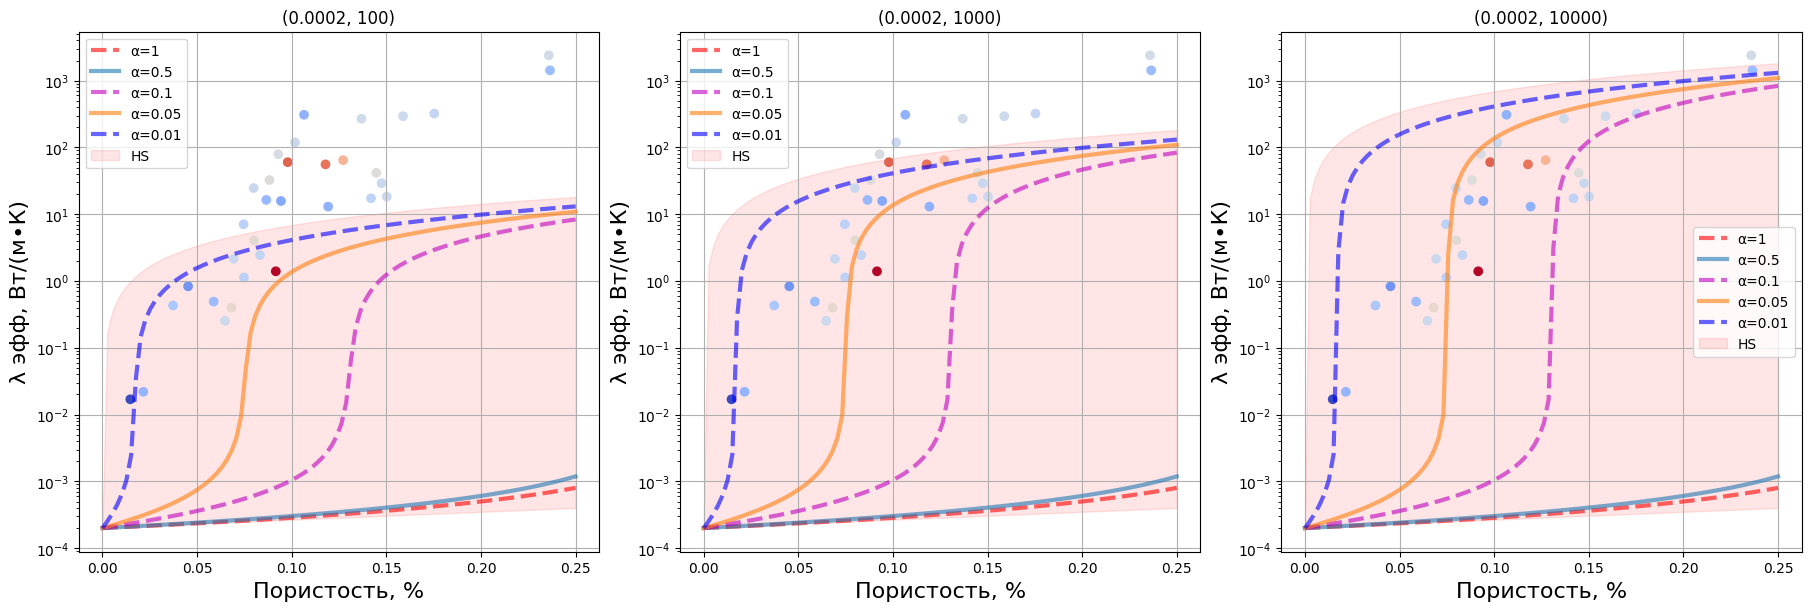

In [ ]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**2),
              (mtrx_perm, 10**3),
              (mtrx_perm, 10**4)]

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 1]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.5]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc(conc, alpha_shape, mlam))


    alpha_shape = [1, 0.1]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.05]
    for i in por:
        conc = [1-i, i]
        ar1.append(effective_tc(conc, alpha_shape, mlam))

    alpha_shape = [1, 0.01]
    for i in por:
        conc = [1-i, i]
        ar2.append(effective_tc(conc, alpha_shape, mlam))

    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=1')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.5')
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label='α=0.1')
    ax.plot(por, ar1, lw=3, alpha=0.6, label='α=0.05')
    ax.plot(por, ar2,'b--', lw=3, alpha=0.6, label='α=0.01')




    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

Решение обратной задачи

In [ ]:
idx = 33
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]/3
mtrx_perm = 2*10**-4

In [ ]:
porosity, exp_permeability, ar_pore, ar_pore_initial

(0.127186314179544, 64.5086, 0.06469633333333334, 0.194089)

In [ ]:
fluid_perm_list = np.logspace(0, 6, num=40, base=10)

calculation_perm =[]

for fluid_comp_perm in fluid_perm_list:
  conc = [1-porosity, porosity]
  alpha_shape = [1, ar_pore]
  components = [mtrx_perm, fluid_comp_perm]
  calculation_perm.append(effective_tc(conc, alpha_shape, components))

In [ ]:

results = pd.DataFrame()
results['Fluid perm'] = fluid_perm_list
results['Calculatioin perm'] = calculation_perm

results['Diff'] = results['Calculatioin perm'].apply(lambda x: abs(np.round((x-exp_permeability)/exp_permeability*100, 2)))

In [ ]:
results = results.sort_values(by=f'Diff')

In [ ]:
results[:3]

,Fluid perm,Calculatioin perm,Diff
23,3455.107295,68.367119,5.98
22,2424.462017,47.973771,25.63
21,1701.254280,33.663680,47.82


### Вывод

## Анализ чувствительности
Рассматривая диапазон изменения проницаемости (k) от $10^{-2}$ до $10^{4}$ мД, изменения $k_{matrix}$ не влияют на эффективное значение, поэтому используем одно фиксированное значение $k_{matrix}$=0.0002 мД из уравнения регресиии "Пористость - Пронициемость".

$k_{fluid}$ в большей степени влияет на эффективное значение, однако начиная с $k_{fluid}$ > $10^{6}$, эффективное значение для $AR_{thermal}$: 0.07 - 0.28 не изменяется. Поэтому рассматриваем $k_{fluid}$ в диапазоне от $10^{0}$ до $10^{6}$ мД.

Рассчитать эффективную проницаемость с использованием $AR_{thermal}$: 0.07 - 0.28 не удалось. Если смотреть на анализ чувствительности, то видно, что кривые для разных $AR_{thermal}$ не попадают на экспериментальные значениея проницаемости. Однако, если занизить систематически $AR_{thermal}$ в 3 раза и больше (т.е. $AR_{thermal}$: 0.01 - 0.05), то можно получить приемлемые решения (погрешность 10%) для эффективного k.

Можно ли вообще использовать модель ОСП? Очень странное поведение модели: уменьшение эффективной проницаемости с увеличением АО, при этом на маленьких АО, эффективная проницаемость растет

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [ ]:
data_ml = data[['Porosity,%', 'AR thermal', 'TC air','TC oil', 'TC 6', 'TC 60', 'TC 180', 'Permeability']]
data_ml.dropna(inplace=True)

target = data_ml ['Permeability']

<ipython-input-69-35f8357ce9db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml.dropna(inplace=True)


In [ ]:
### BEGIN Solution (do not delete this comment)
X, y = data_ml.iloc[:, :-1], target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0xC0FFEE)
### END Solution (do not delete this comment)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features =list(X.columns)

X_train[features] = scaler.fit_transform(X_train[list(features)])
X_test[features] = scaler.fit_transform(X_test[list(features)])

In [ ]:
### BEGIN Solution

lin_reg = []

MODELS = {
    "Linear Regression": LinearRegression(),
    "Ridge regression" : Ridge(),
    "DecisionTree" : DecisionTreeRegressor()
}

for name, model in MODELS.items():
  clf = model.fit(X_train,y_train)

  y_pred = clf.predict(X_train)
  print(f'Trian RMSL {name}: {mse(y_train, y_pred):.2f}')

  if name=='Linear Regression':
    y_pred = clf.predict(X_test)
    lin_reg = y_pred

  y_pred = clf.predict(X_test)
  print(f'Test RMSL {name}: {mse(y_test, y_pred):.2f}', end='\n\n')

### END Solution

Trian RMSL Linear Regression: 2390.56
Test RMSL Linear Regression: 633942.79

Trian RMSL Ridge regression: 3105.12
Test RMSL Ridge regression: 682398.18

Trian RMSL DecisionTree: 0.00
Test RMSL DecisionTree: 595771.00



In [ ]:
clf = LinearRegression().fit(X_train,y_train)
lin = clf.predict(X)

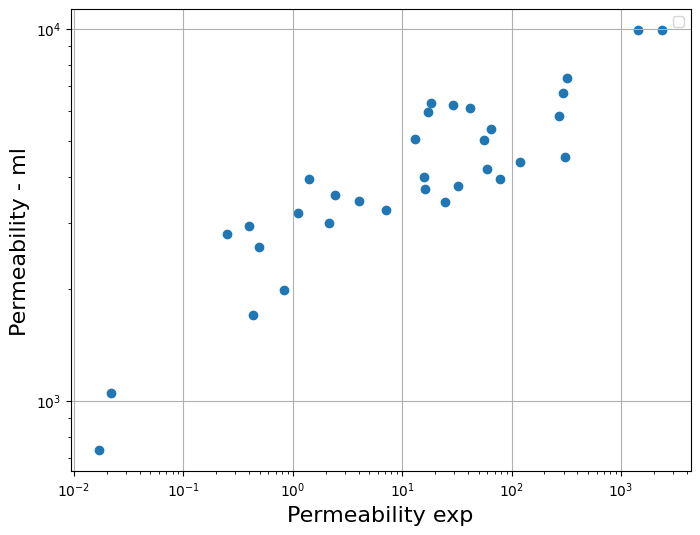

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6))
axs.scatter(target, lin)
# axs.plot([10**-2, 10**4], [10**-2, 10**4])
axs.set_yscale('log', base=10)
axs.set_xscale('log', base=10)
axs.set_ylabel('Permeability - ml', fontsize=16)
axs.set_xlabel('Permeability exp', fontsize=16)
axs.grid(which='major', axis='both', linestyle='-')
axs.legend(loc='best', fontsize='medium')

### f-модель

In [19]:
def effective_tc_f(conc, alpha_shape, lam, f):

    x0=0

    phi = conc

    #------------------depolarization factor calculation-----
    def depolarizaton(alpha):
        if alpha < 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(t2-1)
            t5 = np.arctan(t4)
            t8 = t4 ** 2
            form = t2 * (t4-t5) / t8 / t4
            return form
        elif alpha > 1:
            t1 = alpha ** 2
            t2 = 1 / t1
            t4 = np.sqrt(1-t2)
            t6 = np.log(1+t4)
            t9 = np.log(1-t4)
            t13 = t4 ** 2
            form = t2 * (t6 / 2-t9 / 2-t4) / t13 / t4
            return form
        elif alpha == 1:
            form = 1 / 3
            return form


    depolar_F = []
    for i in alpha_shape:
        depolar_F.append(depolarizaton(i))

    L0 = lam[0]*(1-f) + lam[1]*f

    parall_comp, perpen_comp = [], []
#         print('Тело сравнения', L0)

    for i, j, f in zip(phi, lam, depolar_F):

#             print('Каждая комопонента')
#             print(i, j, f)

        termc_3 = i * j / (L0 * (1-f)+j * f)
        termz_3 = i / (L0 * (1-f)+j * f)

        termc_12 = i * j / (L0 * (1+f) / 2+j * (1-f) / 2)
        termz_12 = i / (L0 * (1+f) / 2+j * (1-f) / 2)

        termc_all = (termc_3+2 * termc_12) / 3
        termz_all = (termz_3+2 * termz_12) / 3

        t16 = termc_all # числитель
        t15 = termz_all # Знаменатель

#             print('ТС матрицы', j)
#             print('t16:' , t16)
#             print('t15:' , t15)

        parall_comp.append(t16)  # числитель формулы (матрица, флюид)
        perpen_comp.append(t15)  # знаменатель формулы (матрица, флюид)

#         print('Параллельный компоненты ТС', parall_comp)
#         print('Перпендикулярные компоненты ТС', perpen_comp)

    L_eff = np.sum(parall_comp) / np.sum(perpen_comp)
#         print('TC eff: ', L_eff, end='\n\n')
    return L_eff

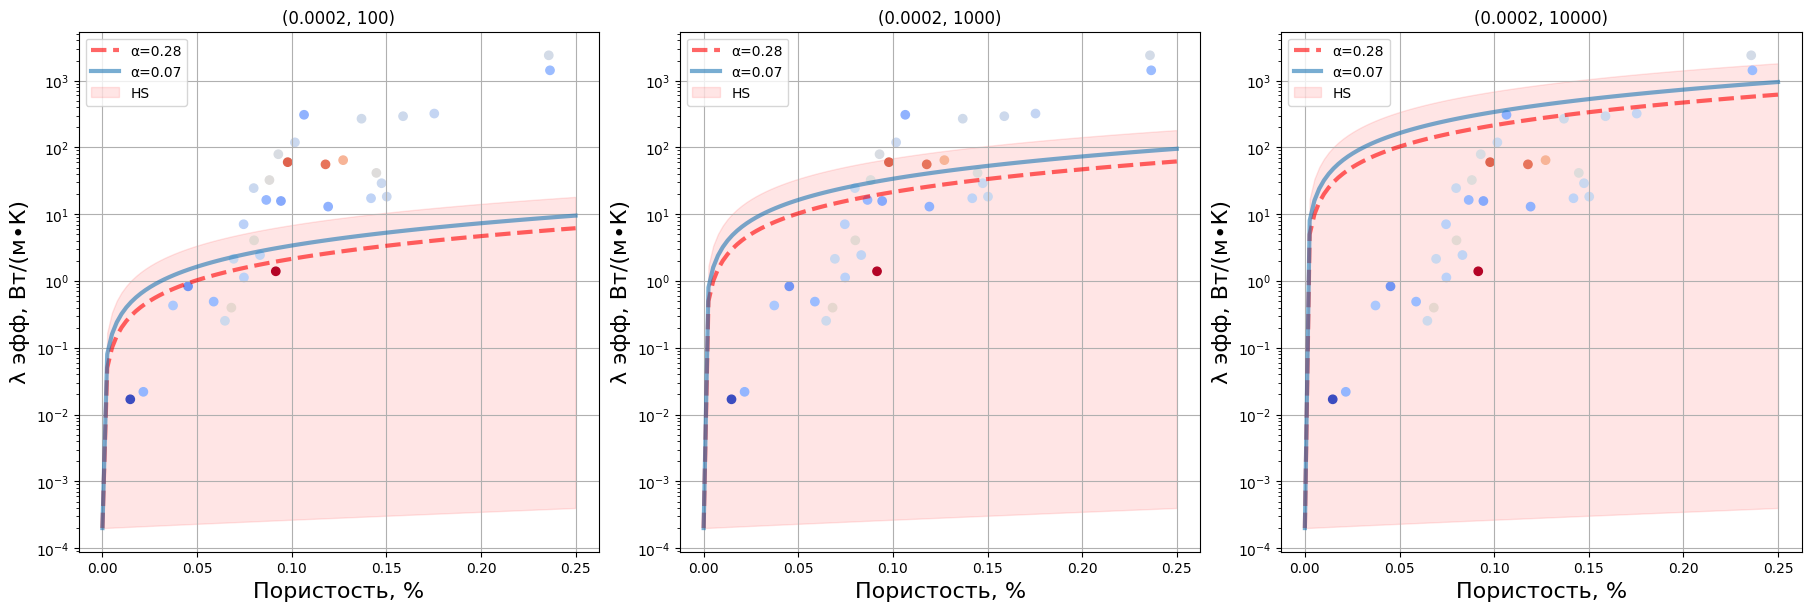

In [27]:
fig5 = plt.figure(layout='constrained', figsize=(18, 6))
axs = fig5.subplots(1, 3, sharex=True)

porosity = np.linspace(0, 0.25, 100)

mtrx_perm=2*10**-4

# matrix_lam = [(3.03, fluid_lam), (3.45, fluid_lam), (3.97, fluid_lam)] # из уравнения регрессии
matrix_lam = [(mtrx_perm, 10**2),
              (mtrx_perm, 10**3),
              (mtrx_perm, 10**4)]

f=0.09

for ax, mlam in zip(axs, matrix_lam):

    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    ar1, ar2 = [], []
    por = porosity

    alpha_shape = [1, 0.28]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))

    alpha_shape = [1, 0.07]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))


    tc_hs_up, tc_hs_dw, tc_hs_mean = [], [], []

    for i in porosity:
        conc = [1-i, i]

        tc_hs_up.append(Upper_Hashin_Strikman(conc, mlam))
        tc_hs_dw.append(Lower_Hashin_Strikman(conc, mlam))

    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label='α=0.28')
    ax.plot(por, tc_eff_water2, lw=3, alpha=0.6, label='α=0.07')


    ax.fill_between(porosity, tc_hs_up, tc_hs_dw, color='r', alpha=.1, label='HS')

    ax.set_ylabel('λ эфф, Вт/(м∙К)', fontsize=16)
    ax.set_xlabel('Пористость, %', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    # Experemental scatter
    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    colors = data['AR thermal']  # Assuming 'permeability' contains values to map colors
    ax.scatter(data["Porosity,%"]/100, data["Permeability"], c=colors, cmap='coolwarm', marker='o')

    ax.legend(loc='best', fontsize='medium')
    ax.set_title(f'{mlam}')

plt.show()

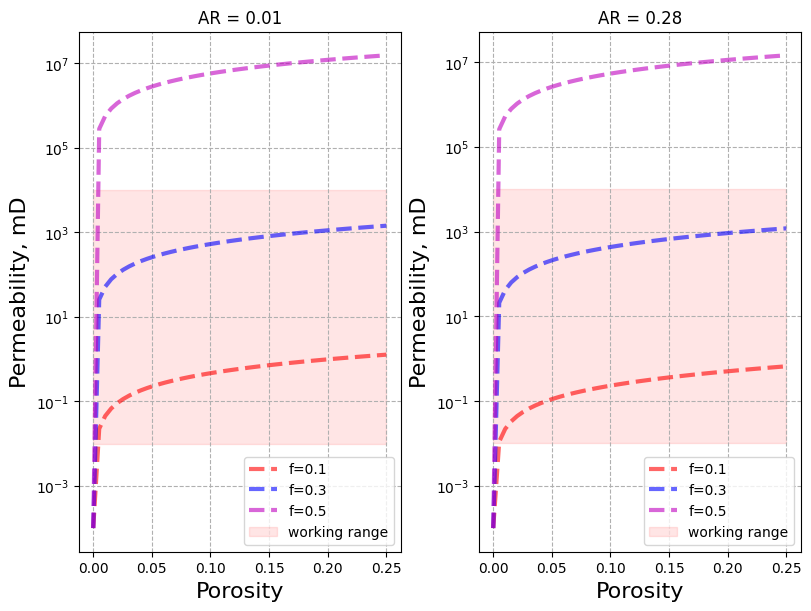

In [24]:
fig5 = plt.figure(layout='constrained', figsize=(8, 6))
axs = fig5.subplots(1, 2, sharex=True)

porosity = np.linspace(0, 0.25, 50)
matrix = 10**-4

ar_list = [0.01, 0.28]

for ax, ar_fluid in zip(axs, ar_list):


    tc_eff_air2, tc_eff_water2, tc_eff_oil2 = [], [], []
    por = porosity
    alpha_shape = [1, ar_fluid]

    f = 0.1
    mlam = [matrix, 10]
    for i in por:
        conc = [1-i, i]
        tc_eff_air2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_air2, 'r--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.3
    mlam = [matrix, 10**4]
    for i in por:
        conc = [1-i, i]
        tc_eff_water2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_water2, 'b--', lw=3, alpha=0.6, label=f'f={f}')

    f = 0.5
    mlam = [matrix, 10**8]
    for i in por:
        conc = [1-i, i]
        tc_eff_oil2.append(effective_tc_f(conc, alpha_shape, mlam, f))
    ax.plot(por, tc_eff_oil2, 'm--', lw=3, alpha=0.6, label=f'f={f}')

    ax.fill_between(porosity, [10**4] * len(porosity), [10**-2] * len(porosity), color='r', alpha=.1, label='working range')

    ax.set_yscale('log', base=10)
    # ax.set_ylim([10**-2, 10**4])
    ax.grid(which='major', axis='both', linestyle='-')

    ax.set_ylabel('Permeability, mD', fontsize=16)
    ax.set_xlabel('Porosity', fontsize=16)
    ax.grid(which='major', axis='both', linestyle='--')
    ax.legend(loc='best', fontsize='medium')
    # ax.set_xlim([0, 0.25])
    # ax.set_xticks(np.arange(0, 0.25, 0.05), fontsize=20)

    ax.set_title(f'AR = {ar_fluid}')

plt.show()

In [62]:
idx = 13
porosity = data["Porosity,%"][idx]/100
exp_permeability = data["Permeability"][idx]
ar_pore_initial = data['AR thermal'][idx]
ar_pore = data['AR thermal'][idx]
mtrx_perm = 2*10**-4

In [63]:
porosity, exp_permeability, ar_pore, ar_pore_initial

(0.07992399227956115, 24.5992, 0.131826, 0.131826)

In [64]:
fluid_perm_list = np.logspace(0, 6, num=50, base=10)
f_list = np.linspace(0., 0.5, 50)

calculation_perm =[]

for fluid_comp_perm in fluid_perm_list:
  for f in f_list:
    conc = [1-porosity, porosity]
    alpha_shape = [1, ar_pore]
    components = [mtrx_perm, fluid_comp_perm]
    calculation_perm.append(effective_tc_f(conc, alpha_shape, components, f))

In [65]:
len(calculation_perm)

2500

In [66]:
results = pd.DataFrame()
results['Fluid perm'] = list(fluid_perm_list) * 50
results['f'] = list(f_list) * 50
results['Calculatioin perm'] = calculation_perm
results['Expermental'] = [exp_permeability]*len(calculation_perm)

results['Diff'] = results['Calculatioin perm'].apply(lambda x: abs(np.round((x-exp_permeability)/exp_permeability*100, 2)))

In [67]:
results = results.sort_values(by=f'Diff')

In [68]:
results[:3]

,Fluid perm,f,Calculatioin perm,Expermental,Diff
1180,4714.866363,0.306122,24.526352,24.5992,0.30
1215,68.664885,0.153061,24.798194,24.5992,0.81
1181,6250.551925,0.316327,24.806658,24.5992,0.84
